In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn import preprocessing

In [139]:
chunksize = 10 ** 6
num_of_chunk = 0
train = pd.DataFrame()

for chunk in pd.read_csv("train.gz", compression='gzip',chunksize=chunksize):
    num_of_chunk += 1
    train = pd.concat([train, chunk.sample(frac=.05, replace=False, random_state=123)], axis=0)
    print('Processing Chunk No. ' + str(num_of_chunk))     
    
train.reset_index(inplace=True)

# 備份train 資料長度，以便稍後df重新分割索引用途
train_len = len(train)
train_len

Processing Chunk No. 1
Processing Chunk No. 2
Processing Chunk No. 3


134189

In [140]:
df_train = train

In [228]:
train_df_full = pd.read_csv("train.gz", compression='gzip', header='infer')

In [229]:
train_df_full.shape

(2683787, 24)

In [141]:
df_test = pd.read_csv("test.gz", compression='gzip', header='infer')

In [142]:
df = pd.concat([df_train, pd.read_csv('test.gz', compression='gzip')]).drop(['index', 'id'], axis=1)

In [143]:
def get_date(hour):
    y = '20'+str(hour)[:2]
    m = str(hour)[2:4]
    d = str(hour)[4:6]
    return y+'-'+m+'-'+d
# 建立weekday欄位，將hour轉換後填入
df['weekday'] = pd.to_datetime(df.hour.apply(get_date)).dt.dayofweek.astype(str)

In [144]:
def get_hour(hour):
    h = str(hour)[-2:]
    return h

df['hour'] = df.hour.apply(get_hour)

In [145]:
df.isnull().sum()

click               473610
hour                     0
C1                       0
banner_pos               0
site_id                  0
site_domain              0
site_category            0
app_id                   0
app_domain               0
app_category             0
device_id                0
device_ip                0
device_model             0
device_type              0
device_conn_type         0
C14                      0
C15                      0
C16                      0
C17                      0
C18                      0
C19                      0
C20                      0
C21                      0
weekday                  0
dtype: int64

In [146]:
#overview of all the distinct values for each column 
len_of_feature_count = []
for i in df.columns[2:23].tolist():
    print(i, ':', len(df[i].astype(str).value_counts()))
    len_of_feature_count.append(len(df[i].astype(str).value_counts()))

C1 : 4
banner_pos : 5
site_id : 2281
site_domain : 2394
site_category : 21
app_id : 1
app_domain : 1
app_category : 1
device_id : 25488
device_ip : 228033
device_model : 3887
device_type : 2
device_conn_type : 2
C14 : 561
C15 : 5
C16 : 6
C17 : 149
C18 : 4
C19 : 33
C20 : 154
C21 : 34


In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607799 entries, 0 to 473609
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   click             134189 non-null  float64
 1   hour              607799 non-null  object 
 2   C1                607799 non-null  int64  
 3   banner_pos        607799 non-null  int64  
 4   site_id           607799 non-null  object 
 5   site_domain       607799 non-null  object 
 6   site_category     607799 non-null  object 
 7   app_id            607799 non-null  object 
 8   app_domain        607799 non-null  object 
 9   app_category      607799 non-null  object 
 10  device_id         607799 non-null  object 
 11  device_ip         607799 non-null  object 
 12  device_model      607799 non-null  object 
 13  device_type       607799 non-null  int64  
 14  device_conn_type  607799 non-null  int64  
 15  C14               607799 non-null  int64  
 16  C15               60

In [148]:
# 建立一個list，將需要轉換行別的特徵名稱存入該list
need_tran_feature = df.columns[2:4].tolist() + df.columns[13:23].tolist()

# 依序將變數轉換為object型別
for i in need_tran_feature:
    df[i] = df[i].astype(str)

In [149]:
# figure out which column has al string length greatee than 10
obj_features = []

for i in range(len(len_of_feature_count)):
    if len_of_feature_count[i] > 10:
        obj_features.append(df.columns[2:23].tolist()[i])
obj_features

['site_id',
 'site_domain',
 'site_category',
 'device_id',
 'device_ip',
 'device_model',
 'C14',
 'C17',
 'C19',
 'C20',
 'C21']

In [150]:
df_describe = df.describe()
df_describe

,click
count,134189.000000
mean,0.201730
std,0.401293
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [151]:
df

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday
0,0.0,03,5,0,656e1ab8,59fdbcde,74073276,ecda2021,2021c8a9,07d7df22,...,0,19771,201,31,1805,0,655,76,36,1
1,0.0,04,5,0,078d3465,dd641cc7,8fd0aea4,ecda2021,2021c8a9,07d7df22,...,0,15707,201,31,1300,0,3,-1,67,1
2,0.0,02,5,0,e9784a08,e10cdbde,74073276,ecda2021,2021c8a9,07d7df22,...,0,21647,201,31,2065,1,515,234,39,1
3,0.0,06,5,0,6ec0e3b4,d7df64b8,dedf689d,ecda2021,2021c8a9,07d7df22,...,0,21680,201,31,2074,3,135,-1,11,1
4,0.0,03,5,0,078d3465,dd641cc7,8fd0aea4,ecda2021,2021c8a9,07d7df22,...,0,15706,201,31,1300,0,3,-1,67,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473605,NaN,05,5,0,8cbf056b,85c6289a,f66779e6,ecda2021,2021c8a9,07d7df22,...,0,8330,201,31,339,3,143,78,11,2
473606,NaN,05,5,1,248ed81a,7fb09894,74073276,ecda2021,2021c8a9,07d7df22,...,0,6616,201,31,154,2,3,131,20,2
473607,NaN,05,5,0,078d3465,dd641cc7,8fd0aea4,ecda2021,2021c8a9,07d7df22,...,0,21763,201,31,2080,0,3,85,209,2
473608,NaN,05,5,1,1b84e3e3,2064e137,f66779e6,ecda2021,2021c8a9,07d7df22,...,0,15705,201,31,1300,0,3,-1,67,2


In [152]:
################################## Store df
################################## Restart from here
df_for_clean = df
df_for_clean

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday
0,0.0,03,5,0,656e1ab8,59fdbcde,74073276,ecda2021,2021c8a9,07d7df22,...,0,19771,201,31,1805,0,655,76,36,1
1,0.0,04,5,0,078d3465,dd641cc7,8fd0aea4,ecda2021,2021c8a9,07d7df22,...,0,15707,201,31,1300,0,3,-1,67,1
2,0.0,02,5,0,e9784a08,e10cdbde,74073276,ecda2021,2021c8a9,07d7df22,...,0,21647,201,31,2065,1,515,234,39,1
3,0.0,06,5,0,6ec0e3b4,d7df64b8,dedf689d,ecda2021,2021c8a9,07d7df22,...,0,21680,201,31,2074,3,135,-1,11,1
4,0.0,03,5,0,078d3465,dd641cc7,8fd0aea4,ecda2021,2021c8a9,07d7df22,...,0,15706,201,31,1300,0,3,-1,67,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473605,NaN,05,5,0,8cbf056b,85c6289a,f66779e6,ecda2021,2021c8a9,07d7df22,...,0,8330,201,31,339,3,143,78,11,2
473606,NaN,05,5,1,248ed81a,7fb09894,74073276,ecda2021,2021c8a9,07d7df22,...,0,6616,201,31,154,2,3,131,20,2
473607,NaN,05,5,0,078d3465,dd641cc7,8fd0aea4,ecda2021,2021c8a9,07d7df22,...,0,21763,201,31,2080,0,3,85,209,2
473608,NaN,05,5,1,1b84e3e3,2064e137,f66779e6,ecda2021,2021c8a9,07d7df22,...,0,15705,201,31,1300,0,3,-1,67,2


In [153]:
def obj_clean(X):
    # 定義一個縮減資料值的function，每次處理一個特徵向量

    def get_click_rate(x):
        # 定義一個取得點擊率的function
        temp = df_train[df_train[X.columns[0]] == x]
        res = round((temp.click.sum() / temp.click.count()),3)
        return res

    def get_type(V, str):
        # 定義一個取得新資料值之級距判斷的function
        very_high = df_describe.loc['mean','click'] + 0.04
        higher = df_describe.loc['mean','click'] + 0.02
        lower = df_describe.loc['mean','click'] - 0.02
        very_low = df_describe.loc['mean','click'] - 0.04

        vh_type = V[V[str] > very_high].index.tolist()
        hr_type = V[(V[str] > higher) & (V[str] < very_high)].index.tolist()
        vl_type = V[V[str] < very_low].index.tolist()
        lr_type = V[(V[str] < lower) & (V[str] > very_low)].index.tolist()

        return vh_type, hr_type, vl_type, lr_type

    def clean_function(x):
        # 定義一個依據級距轉換資料值的function
        # 判斷之依據為：總平均點擊率的正負  4% 為very_high(low), 總平均點擊率的正負 2％為higher (lower)
        while x in type_[0]:
            return 'very_high'
        while x in type_[1]:
            return 'higher'
        while x in type_[2]:
            return 'very_low'
        while x in type_[3]:
            return 'lower'
        return 'mid'
        
    print('Run: ', X.columns[0])
    fq = X[X.columns[0]].value_counts()
    # 建立一個暫存的資料值頻率列表
    # 理論上，將全部的資料值都進行分類轉換，可得到最佳效果；實務上為了執行時間效能，將捨去頻率低於排名前1000 row以後的資料值。
    if len(fq) > 1000:
        fq = fq[:1000]

    # 將頻率列表轉換為dataframe，並將index填入一個新的欄位。
    fq = pd.DataFrame(fq)
    fq['new_column'] = fq.index    

    # 使用index叫用get_click_rate function，取得每個資料值的點擊率
    fq['click_rate'] = fq.new_column.apply(get_click_rate)

    # 叫用 get_type function取得分類級距，並儲存為一個list，以便提供給下一個clean_function使用
    type_ = get_type(fq, 'click_rate')

    # 叫用 clean_funtion funtion，回傳轉換後的特徵向量
    return X[X.columns[0]].apply(clean_function)

# 使用for 迴圈將需轉換的特徵輸入到 obj_clean function
for i in obj_features:    
    df_for_clean[[i]] = obj_clean(df_for_clean[[i]])

df_for_clean

Run:  site_id
Run:  site_domain
Run:  site_category
Run:  device_id
Run:  device_ip
Run:  device_model
Run:  C14
Run:  C17
Run:  C19
Run:  C20
Run:  C21


,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday
0,0.0,03,5,0,very_low,very_low,mid,ecda2021,2021c8a9,07d7df22,...,0,mid,201,31,mid,0,mid,mid,mid,1
1,0.0,04,5,0,mid,mid,mid,ecda2021,2021c8a9,07d7df22,...,0,mid,201,31,mid,0,mid,mid,mid,1
2,0.0,02,5,0,very_low,very_low,mid,ecda2021,2021c8a9,07d7df22,...,0,mid,201,31,mid,1,mid,mid,mid,1
3,0.0,06,5,0,very_low,very_low,very_low,ecda2021,2021c8a9,07d7df22,...,0,mid,201,31,mid,3,mid,mid,mid,1
4,0.0,03,5,0,mid,mid,mid,ecda2021,2021c8a9,07d7df22,...,0,mid,201,31,mid,0,mid,mid,mid,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473605,NaN,05,5,0,very_low,very_low,very_high,ecda2021,2021c8a9,07d7df22,...,0,mid,201,31,mid,3,mid,mid,mid,2
473606,NaN,05,5,1,very_high,very_high,mid,ecda2021,2021c8a9,07d7df22,...,0,mid,201,31,mid,2,mid,mid,mid,2
473607,NaN,05,5,0,mid,mid,mid,ecda2021,2021c8a9,07d7df22,...,0,mid,201,31,mid,0,mid,mid,mid,2
473608,NaN,05,5,1,very_low,very_low,very_high,ecda2021,2021c8a9,07d7df22,...,0,mid,201,31,mid,0,mid,mid,mid,2


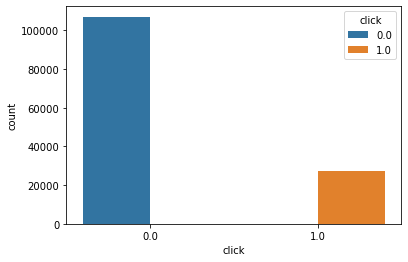

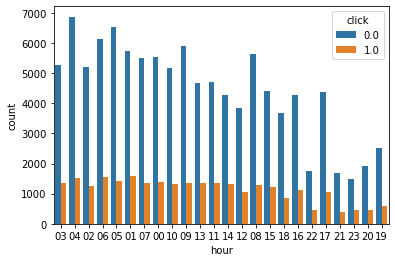

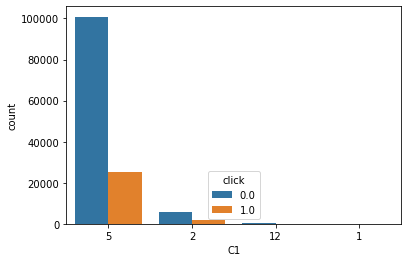

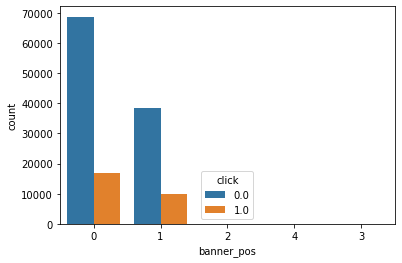

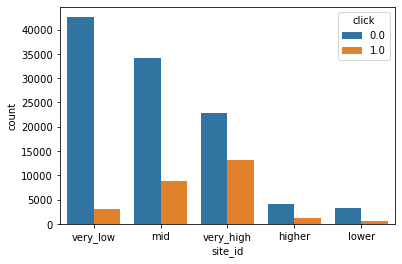

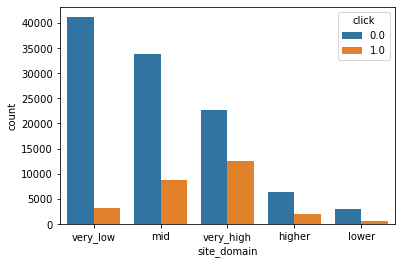

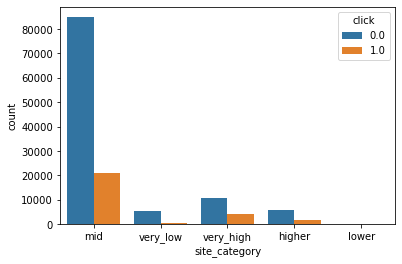

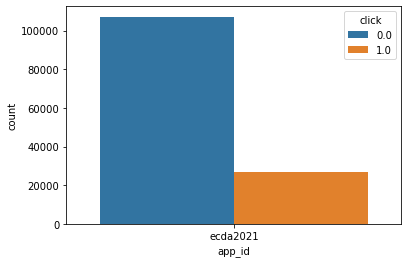

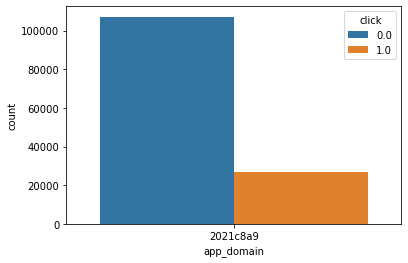

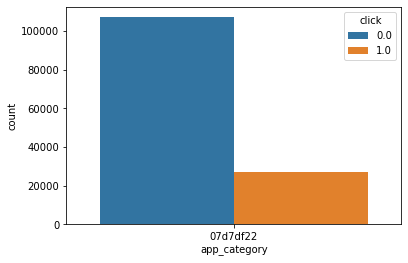

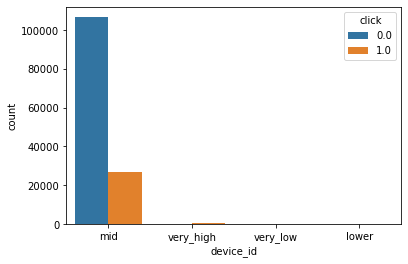

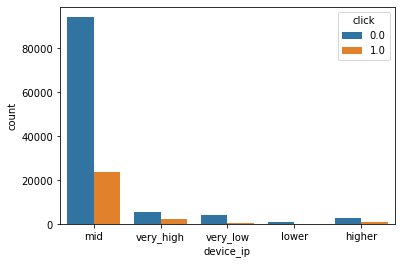

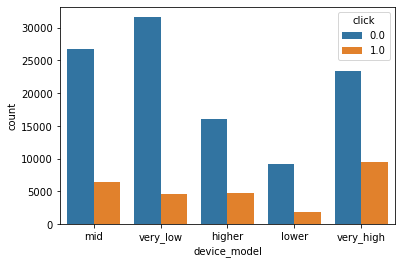

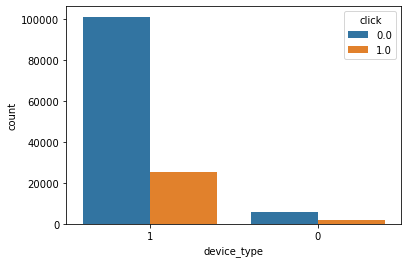

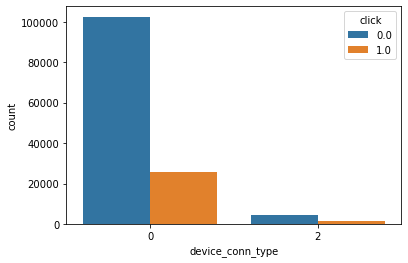

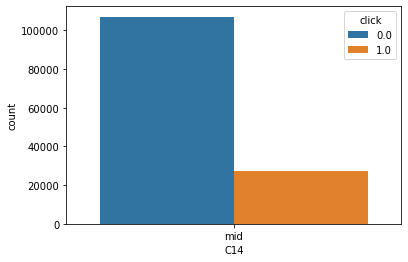

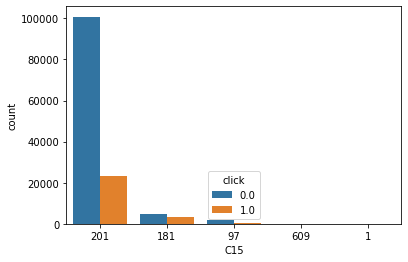

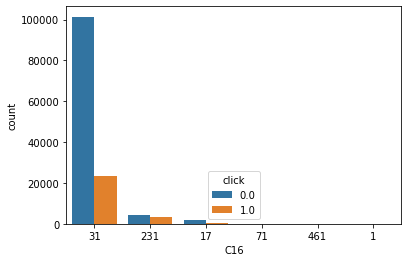

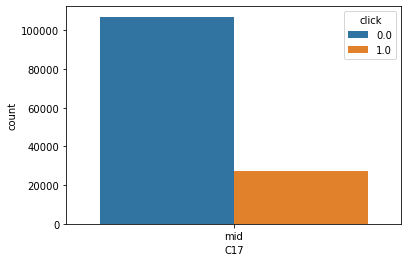

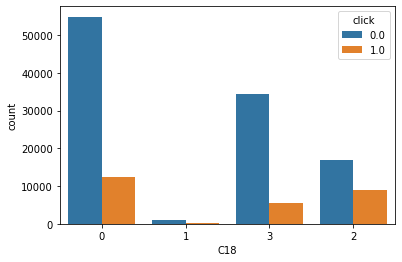

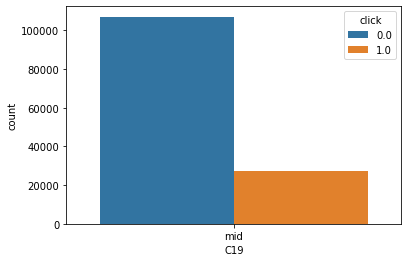

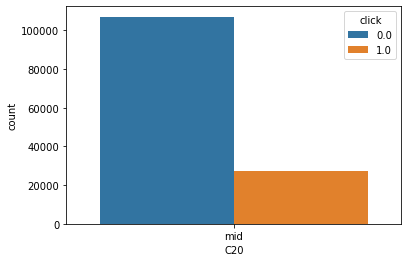

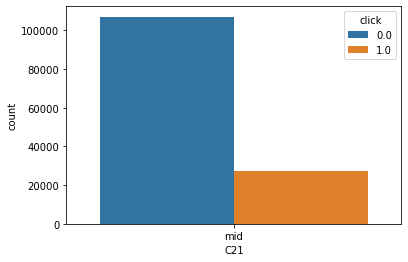

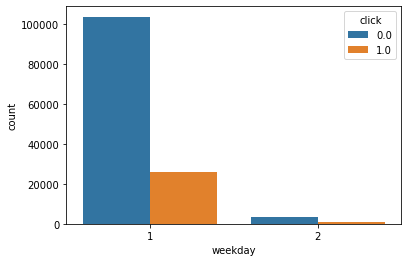

In [154]:
for i in df_for_clean.columns:
    sns.countplot(x = i, hue = "click", data = df_for_clean)
    plt.show()

In [155]:
df_for_clean.drop(['device_id','app_id','app_domain','app_category', 'C14', 'C17', 'C19', 'C20', 'C21'], axis=1, inplace=True)

In [156]:
df_for_clean = pd.get_dummies(df_for_clean)

In [188]:
df_for_clean

,click,hour_00,hour_01,hour_02,hour_03,hour_04,hour_05,hour_06,hour_07,hour_08,...,C16_231,C16_31,C16_461,C16_71,C18_0,C18_1,C18_2,C18_3,weekday_1,weekday_2
0,0.0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
1,0.0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
2,0.0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
3,0.0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,1,0
4,0.0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473605,NaN,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,1
473606,NaN,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,1
473607,NaN,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,1
473608,NaN,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,1


In [158]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [166]:
# pre_X = df_for_clean[df_for_clean['click'] == 0].sample(n=len(df_for_clean[df_for_clean['click'] == 1]), random_state=123)
# train_for_model = pd.concat([pre_X, df_for_clean[df_for_clean['click'] == 1]]).sample(frac=1)
# train_for_model_x = train_for_model.loc[:,(train_for_model.columns != 'click')]
# train_for_model_y = train_for_model[['click']]


In [174]:
train_part = df_for_clean[:train_len]
test_part = df_for_clean[train_len:]

In [186]:
X = train_part.loc[:,(train_part.columns != 'click')]
y = train_part[['click']]

In [104]:
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)

### Full train part, rf_cla, 20_depth, eliminate unimportant feature

In [215]:
parameters = {
    'n_estimators': [100],
    'max_depth':range(5,10),
    'min_samples_split': np.linspace(0.1, 0.5, 5, endpoint=True),
    'min_samples_leaf': np.linspace(0.1, 0.5, 5, endpoint=True),
    "criterion":["gini", "entropy"],
}

rf_cla = GridSearchCV(RandomForestClassifier(), param_grid=parameters, scoring='roc_auc', cv=10, verbose=1, n_jobs=-1)
rf_cla.fit(X, np.ravel(y))
rf_cla.best_score_,rf_cla.best_params_

Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 21.9min finished


(0.7130284346732713,
 {'criterion': 'gini',
  'max_depth': 8,
  'min_samples_leaf': 0.1,
  'min_samples_split': 0.30000000000000004,
  'n_estimators': 100})

In [216]:
rf_cla_model = RandomForestClassifier(criterion = "gini", max_depth =8, min_samples_leaf =0.1 , min_samples_split =0.3 , n_estimators = 100)
rf_cla_model = rf_cla_model.fit(X, np.ravel(y))

In [221]:
feature_importances = pd.DataFrame(rf_cla_model.feature_importances_)
feature_importances.index = X.columns
feature_importances = feature_importances.sort_values(0,ascending=False)
feature_importances

,0
site_id_very_high,0.205130
site_id_very_low,0.191520
C18_2,0.108566
site_domain_very_low,0.104027
site_domain_very_high,0.076166
...,...
hour_23,0.000000
hour_22,0.000000
hour_21,0.000000
hour_20,0.000000


In [218]:
X_test = test_part.loc[:,(test_part.columns != 'click')]
# y_test = test_part[['click']]

In [219]:
X_train_short = X[feature_importances.index[:int(len(feature_importances)/3)]]
X_test_short = X_test[feature_importances.index[:int(len(feature_importances)/3)]]

In [222]:
parameters = {
    'n_estimators': [100],
    'max_depth':range(5,10),
    'min_samples_split': np.linspace(0.1, 0.5, 5, endpoint=True),
    'min_samples_leaf': np.linspace(0.1, 0.5, 5, endpoint=True),
    "criterion":["gini", "entropy"],
}

rf_cla = GridSearchCV(RandomForestClassifier(), param_grid=parameters, scoring='roc_auc', cv=10, verbose=1, n_jobs=-1)
rf_cla.fit(X_train_short, np.ravel(y))
rf_cla.best_score_,rf_cla.best_params_

Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 21.4min finished


(0.7128236010742882,
 {'criterion': 'gini',
  'max_depth': 7,
  'min_samples_leaf': 0.1,
  'min_samples_split': 0.4,
  'n_estimators': 100})

In [223]:
rf_cla_model_short = RandomForestClassifier(criterion = "gini", max_depth =7, min_samples_leaf =0.1 , min_samples_split =0.4 , n_estimators = 100)
rf_cla_model_short = rf_cla_model_short.fit(X_train_short, np.ravel(y))

In [199]:
## Fit with short feature
# rf_cla_model = rf_cla_model.fit(X_train_short, np.ravel(y))

In [224]:
y_pred_prob = rf_cla_model_short.predict_proba(X_test_short)

In [225]:
output_dic_rfclassifier = {"id": list(df_test["id"]), "ctr": y_pred_prob[:, 1]}
output_df_rfclassifier = pd.DataFrame.from_dict(output_dic_rfclassifier)

In [226]:
output_df_rfclassifier

,id,ctr
0,2683788,0.110619
1,2683789,0.107357
2,2683790,0.211869
3,2683791,0.112911
4,2683792,0.112638
...,...,...
473605,3157393,0.110619
473606,3157394,0.302795
473607,3157395,0.200466
473608,3157396,0.126288


In [227]:
output_df_rfclassifier.to_csv("submission_v9.csv", index=False)